In [ ]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
#help streamline the process of building and deploying computer vision applications using OpenCV.
import matplotlib.image as mpimg
from collections import OrderedDict # ensures that the order of keys is maintained,
from skimage import io, transform  # skimage (scikit-image) for image I/O and transformations
from math import *  # Import all mathematical functions from the math module
import xml.etree.ElementTree as ET  # for parsing and creating XML (eXtensible Markup Language) documents
import torch  # Core PyTorch library for tensor operations
import torchvision  # PyTorch's computer vision package
import torch.nn as nn  # PyTorch module for creating neural network layers
import torch.optim as optim  # PyTorch module for optimization algorithms
import torch.nn.functional as F  # PyTorch module "for functional operations (e.g., activation functions)
import torchvision.transforms.functional as TF  # Functional transformations for image preprocessing in torchvision
from torchvision import datasets, models, transforms  # Datasets: for loading and using common datasets, models: pre-trained models, transforms: common image transformations
from torch.utils.data import Dataset  # PyTorch class for creating custom datasets
from torch.utils.data import DataLoader  # PyTorch class for creating data loaders to iterate over datasets


* This command extracts the contents of the downloaded tarball. The flags used are:
-x: Extract files from an archive.
-v: Verbose output (list files as they are being extracted).
-z: Filter the archive through gzip.
-f: Specify the filename of the archive.


In [ ]:
# %%capture  # Jupyter magic command to suppress the output of the following cell
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz  # Download the dataset tarball using wget
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'  # Extract the contents of the tarball
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'  # Remove the tarball after extraction to save space


Streaming output truncated to the last 5000 lines.
ibug_300W_large_face_landmark_dataset/helen/trainset/280470418_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2896253715_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2777541034_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2540799498_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2966782955_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/1421150832_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2267947745_1.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2599011432_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2652792032_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2880878213_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2826061016_1_mirror.jpg
ibug_300W_large_face_landmark_dataset/helen/trainset/2234753986_1.pts
ibug_300W_large_face_landmark_dataset/helen/trainset/2233368704_2.jpg
ibug_

# Visualize the dataset

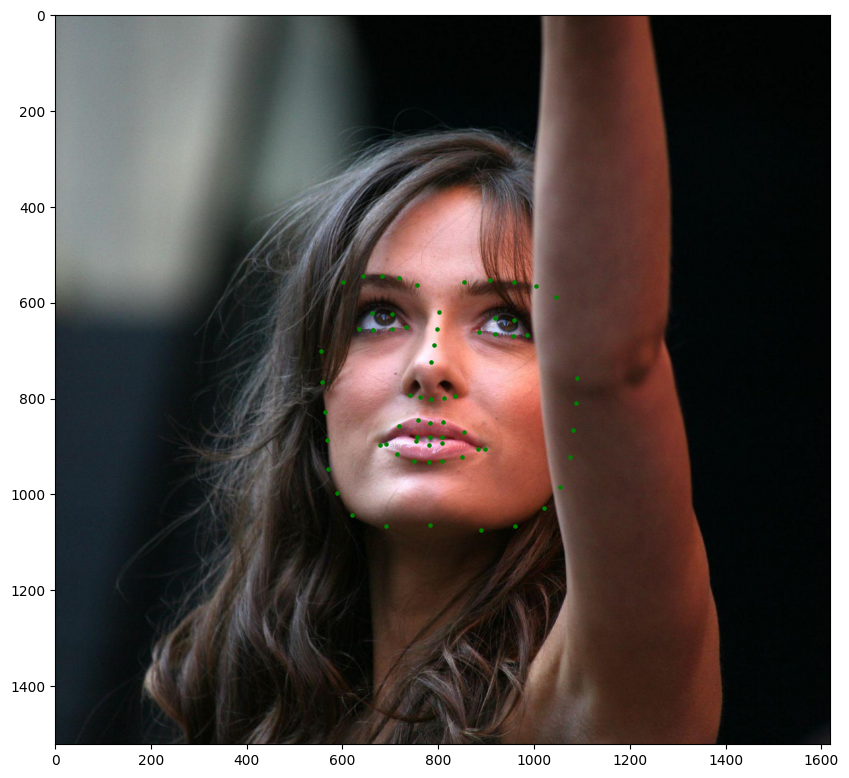

In [ ]:

# Open the landmarks file
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')

# Read all lines from the file and exclude the first three and the last line
points = file.readlines()[3:-1]

# Initialize an empty list to store landmark coordinates
landmarks = []

# Process each point line to extract the x and y coordinates
for point in points:
    x, y = point.split(' ')  # Split the line by space to get x and y coordinates
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])  # Convert to float, floor the values, and append to landmarks

# Convert the list of landmarks to a numpy array for easier manipulation
landmarks = np.array(landmarks)

# Plotting the image and landmarks
plt.figure(figsize=(10, 10))  # Create a figure with size 10x10 inches
image_path = 'ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'
plt.imshow(mpimg.imread(image_path))  # Read and display the image
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=5, c='g')  # Scatter plot of landmarks with small green dots
plt.show()  # Display the plot

# Create Dataset classes
* The labels_ibug_300W_train.xml consists of the input images and landmarks and bounding box to crop the face. I will store all these values in the list so that we could easily access them during the training process.

In [ ]:
class Transforms():
  def __init__(self):
    pass
   #Method to rotate the image and landmarks by a random angle
  def rotate(self, image, landmarks, angle):
      # Generate a random angle within the range [-angle, +angle]
      angle = random.uniform(-angle, +angle)
     # Create a transformation matrix for the rotation
      transformation_matrix = torch.tensor([
          [+cos(radians(angle)), -sin(radians(angle))],
          [+sin(radians(angle)), +cos(radians(angle))]
      ])
     # Rotate the image using imutils
      image = imutils.rotate(np.array(image), angle)
     # Normalize landmarks to center them around (0, 0)
      landmarks = landmarks - 0.5
     # Apply the transformation matrix to the landmarks
      new_landmarks = np.matmul(landmarks, transformation_matrix)
     # Re-normalize landmarks to their original scale
      new_landmarks = new_landmarks + 0.5
     # Convert the image back to a PIL image
      return Image.fromarray(image), new_landmarks
 # Method to resize the image and landmarks to a specific size
  def resize(self, image, landmarks, img_size):
      # Resize the image using torchvision.transforms.functional
      image = TF.resize(image, img_size)
      return image, landmarks #he spatial relationships between the landmarks and the image dimensions remain the same.
 # Method to apply color jittering to the image
  def color_jitter(self, image, landmarks):
      # Create a ColorJitter transform with specified parameters
      color_jitter = transforms.ColorJitter(
          brightness=0.3,
          contrast=0.3,
          saturation=0.3,
          hue=0.1
      )
     # Apply the ColorJitter transform to the image
      image = color_jitter(image)
      return image, landmarks
 # Method to crop the face region from the image based on given crop parameters
  def crop_face(self, image, landmarks, crops):
    left = int(crops['left'])  # Get left coordinate
    top = int(crops['top'])    # Get top coordinate
    width = int(crops['width'])  # Get width
    height = int(crops['height'])  # Get height
  #  Crop the image using the given coordinates
    image = TF.crop(image, top, left, height, width)
  #  Get the shape of the cropped image
    img_shape = np.array(image).shape
  #  Adjust the landmarks based on the cropping
    landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
  #  Normalize the landmarks to the cropped image dimensions
    landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
    return image, landmarks
 # Call method to apply all the transformations in sequence
  def __call__(self, image, landmarks, crops):
      image = Image.fromarray(image)  # Convert numpy array to PIL image
      image, landmarks = self.crop_face(image, landmarks, crops)  # Crop the face
      image, landmarks = self.resize(image, landmarks, (224, 224))  # Resize the image and landmarks
      image, landmarks = self.color_jitter(image, landmarks)  # Apply color jitter
      image, landmarks = self.rotate(image, landmarks, angle=10)  # Rotate the image and landmarks
     # Convert the image to a tensor
      image = TF.to_tensor(image)
      # Normalize the image tensor
      image = TF.normalize(image, [0.5], [0.5])
      return image, landmarks  # Return the transformed image and landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, transform=None):
        # Parse the XML file containing image filenames and landmarks
        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        # Initialize lists to store image filenames, landmarks, and crop parameters
        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        # Iterate over each filename in the XML tree
        for filename in root[2]:
            # Append the image filename to the list
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            # Append the crop parameters to the list
            self.crops.append(filename[0].attrib)

            # Extract landmarks for each filename
            landmark = []
            for num in range(68):
                # Extract x and y coordinates of each landmark
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            # Append landmarks for the current image to the list
            self.landmarks.append(landmark)

        # Convert landmarks list to a numpy array of type float32
        self.landmarks = np.array(self.landmarks).astype('float32')

        # Ensure the lengths of image filenames and landmarks lists are equal
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        # Return the total number of images in the dataset
        return len(self.image_filenames)

    def __getitem__(self, index):
        # Read the image using OpenCV
        image = cv2.imread(self.image_filenames[index], 0)  # Read image in grayscale

        # Get landmarks for the current image
        landmarks = self.landmarks[index]

        # Apply transformations if specified
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        # Normalize landmarks to range [-0.5, 0.5]
        landmarks = landmarks - 0.5

        # Return the image and landmarks as tensors
        return image, landmarks

# Create an instance of FaceLandmarksDataset with Transforms
dataset = FaceLandmarksDataset(Transforms())

# Visualize Train Transforms:

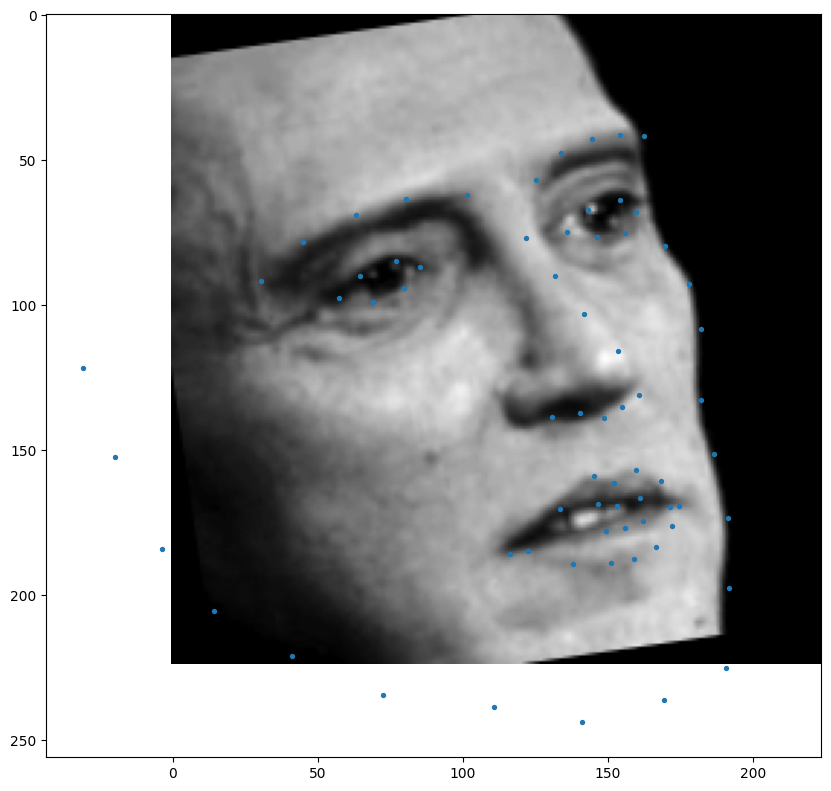

In [ ]:
image, landmarks = dataset[0]
# Convert landmarks from normalized coordinates to pixel coordinates
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

# Split the Dataset for Training and Prediction of Face Landmarks

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

The length of Train set is 6000
The length of Valid set is 666


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Testing the shape of input data:


In [ ]:
images, landmarks = next(iter(train_loader)) # allowing to iterate through the dataset in batches
print(images.shape)
print(landmarks.shape)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])


In [ ]:
class Network(nn.Module):
    def __init__(self, num_classes=136):
        super().__init__()
        self.model_name = 'resnet18'
        # Load pre-trained ResNet-18 model
        self.model = models.resnet18()
        # Modify the first convolutional layer to accept grayscale images (1 channel)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        # Modify the fully connected layer (classifier) to output num_classes classes
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    def forward(self, x):
        # Forward pass through the model
        x = self.model(x)
        return x

# Helper Functions:

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    """
    Prints a progress message in the same line, overwriting the previous message.
    Args:
    - step (int): The current step or iteration number.
    - total_step (int): The total number of steps or iterations.
    - loss (float): The loss value at the current step.
    - operation (str): Specifies whether it's for training or validation ('train' or 'valid').
    """
    # Clear the current line
    sys.stdout.write('\r')
    # Construct the progress message based on the operation (train or valid)
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    # Flush the stdout buffer to ensure immediate display of the message
    sys.stdout.flush()


# Training the Neural Network for Face Landmarks Detection

In [ ]:
# Set anomaly detection to True for PyTorch autograd
torch.autograd.set_detect_anomaly(True)

# Initialize the network and move it to GPU
network = Network()
network.cuda()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

# Initialize variables to keep track of minimum validation loss and number of epochs
loss_min = np.inf
num_epochs = 1

# Start timer to measure elapsed time
start_time = time.time()

# Iterate over epochs
for epoch in range(1, num_epochs+1):
    # Initialize loss variables for training and validation
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    # Set the network to training mode
    network.train()

    # Iterate over training data batches
    for step in range(1, len(train_loader)+1):

        # Fetch images and landmarks from the training loader
        images, landmarks = next(iter(train_loader))

        # Move data to GPU
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0), -1).cuda()

        # Forward pass: compute predicted landmarks
        predictions = network(images)

        # Zero the gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss_train_step = criterion(predictions, landmarks)
        loss_train_step.backward()
        optimizer.step()

        # Accumulate training loss and compute running loss
        loss_train += loss_train_step.item()
        running_loss = loss_train / step

        # Print training progress
        print_overwrite(step, len(train_loader), running_loss, 'train')

    # Set the network to evaluation mode
    network.eval()

    # Disable gradient calculation for validation
    with torch.no_grad():

        # Iterate over validation data batches
        for step in range(1, len(valid_loader)+1):

            # Fetch images and landmarks from the validation loader
            images, landmarks = next(iter(valid_loader))

            # Move data to GPU
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0), -1).cuda()

            # Forward pass: compute predicted landmarks
            predictions = network(images)

            # Compute validation loss
            loss_valid_step = criterion(predictions, landmarks)

            # Accumulate validation loss and compute running loss
            loss_valid += loss_valid_step.item()
            running_loss = loss_valid / step

            # Print validation progress
            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    # Compute average loss for the epoch
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    # Print epoch summary
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')

    # Save the model if validation loss is minimized
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth')
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')

# End of training loop
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time() - start_time))


Valid Steps: 84/84  Loss: 0.0063 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0218  Valid Loss: 0.0063
--------------------------------------------------

Minimum Validation Loss of 0.0063 at epoch 1/1
Model Saved

Training Complete
Total Elapsed Time : 658.2381148338318 s


Total number of test images: 666
Elapsed Time : 1.1845848560333252


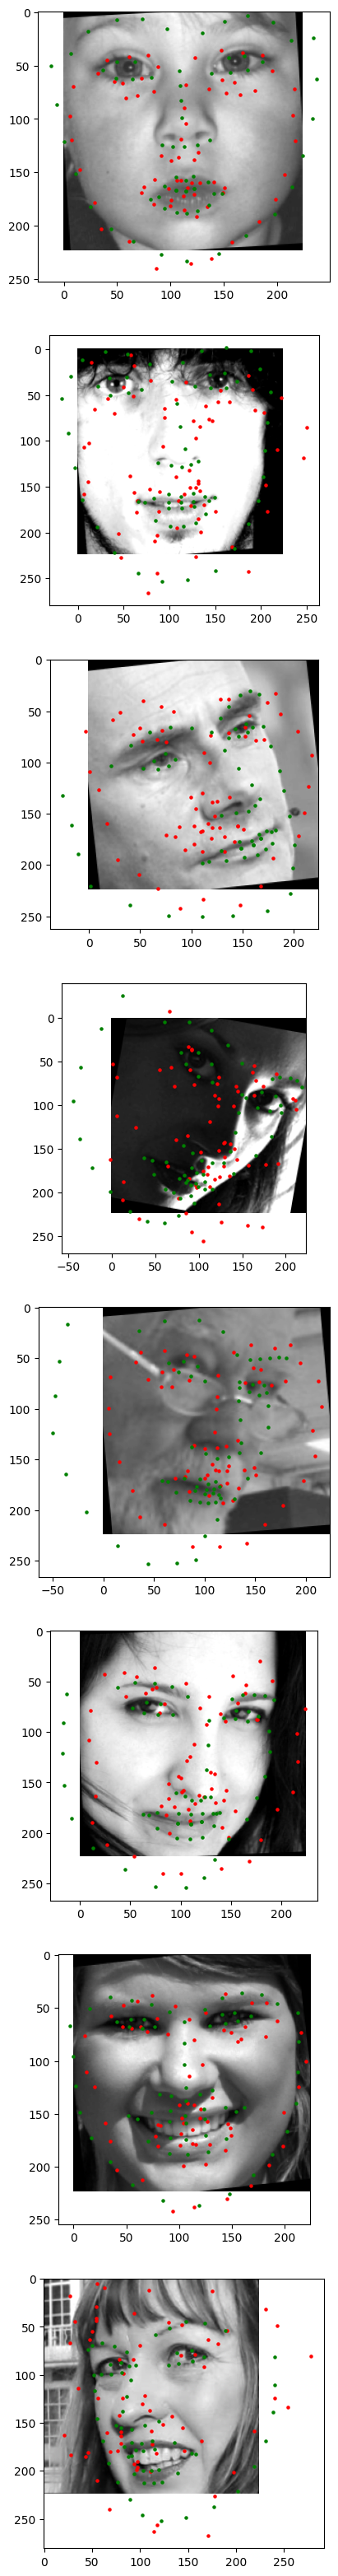

In [ ]:
# Start timer to measure elapsed time
start_time = time.time()

# Disable gradient calculation for inference
with torch.no_grad():
    # Load the best trained network
    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth'))
    best_network.eval()

    # Fetch a batch of images and landmarks from the validation loader
    images, landmarks = next(iter(valid_loader))

    # Move images to GPU and convert landmarks from normalized coordinates to pixel coordinates
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224

    # Perform inference using the best network and convert predictions to pixel coordinates
    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1, 68, 2)

    # Plot the images with ground truth and predicted landmarks
    plt.figure(figsize=(10, 40))
    for img_num in range(8):
        plt.subplot(8, 1, img_num + 1)
        plt.imshow(images[img_num].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num, :, 0], predictions[img_num, :, 1], c='r', s=5)
        plt.scatter(landmarks[img_num, :, 0], landmarks[img_num, :, 1], c='g', s=5)

# Print total number of test images
print('Total number of test images: {}'.format(len(valid_dataset)))

# End timer and print elapsed time
end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time))
